In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder
import sklearn.metrics

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [61]:
folder_dir = '../data/'
data_path = "data_clean.csv"
data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
data=data.drop('Unnamed: 0',axis=1)

#=data.head(500)

In [62]:
data.shape

(3700449, 37)

In [63]:
data.isnull().any()[data.isnull().any()]

outcome    True
nasty      True
dtype: bool

In [64]:
### Create features
data.columns

Index(['date', 'umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px',
       'pz', 'break_y', 'break_angle', 'break_length', 'pitch_type',
       'spin_dir', 'nasty', 'pitch_count', 'descr', 'y', 'year', 'count_b_p',
       'strikes', 'balls', 'pitcher', 'pitch_type.1', 'rolling_start_speed',
       'long_rolling_start_speed', 'zone_1', 'zone_2', 'zone_3', 'zone_4',
       'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12',
       'zone_13'],
      dtype='object')

### Generate distance,speed diff, catgorize pitch type

In [65]:
data['dist']=np.sqrt(data['px']**2+data['pz']**2)
data['speed_diff']=data['rolling_start_speed']-data['long_rolling_start_speed']

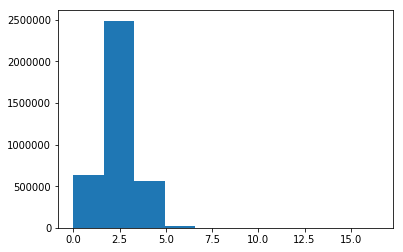

In [66]:
plt.hist(data['dist']);

In [67]:
data['pitch_type'].unique()

array(['FF', 'SL', 'FS', 'FC', 'CH', 'KC', 'FT', 'CU', 'SI'], dtype=object)

In [68]:
#a0.to_numeric(data['pitch_type'],errors='coerce')

In [69]:
pitch_types=pd.get_dummies(data['pitch_type'],prefix='pitch_type')
data=pd.concat([data,pitch_types],axis=1)
pitch_types=0

In [70]:
data.columns

Index(['date', 'umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px',
       'pz', 'break_y', 'break_angle', 'break_length', 'pitch_type',
       'spin_dir', 'nasty', 'pitch_count', 'descr', 'y', 'year', 'count_b_p',
       'strikes', 'balls', 'pitcher', 'pitch_type.1', 'rolling_start_speed',
       'long_rolling_start_speed', 'zone_1', 'zone_2', 'zone_3', 'zone_4',
       'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12',
       'zone_13', 'dist', 'speed_diff', 'pitch_type_CH', 'pitch_type_CU',
       'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_FT',
       'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL'],
      dtype='object')

## Train, test, validation split

In [71]:
model_feats=['px','pz','pfx_x','pfx_z','start_speed','spin_dir','pitch_count','balls','strikes','date',
             'y','rolling_start_speed']

model_feats=['px','pz','pfx_x','pfx_z','start_speed','spin_dir','pitch_count','balls','strikes','date',
             'y','speed_diff','dist','pitch_type_CH', 'pitch_type_CU','pitch_type_FC', 'pitch_type_FF', 
             'pitch_type_FS', 'pitch_type_FT', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']
model_feats=['px','pz','pfx_x','pfx_z','y','strikes','date']
#y=data['y']
#data=data[model_feats]

In [72]:
data["date"] = pd.to_datetime(data["date"])

start = data["date"].searchsorted(datetime.datetime(2012, 1, 1))[0]
#start
end = data["date"].searchsorted(datetime.datetime(2016, 1, 1))[0] - 1
#end

X_train = data[model_feats].loc[start:end]
y_train=X_train['y']
X_train=X_train.drop(['y','date'],axis=1)

X_test=data[model_feats][end:]
y_test=X_test['y']
X_test=X_test.drop(['y','date'],axis=1)
data=0

### Random Forest

In [73]:
steps= [('rf', RandomForestClassifier(oob_score=True))]

mypipeline= Pipeline(steps)

param_grid_rf = dict(
    #rf__min_samples_leaf= np.logspace(4, 5, num=5, base=4, endpoint=False, dtype=int),
    #rf__min_samples_split= [100, 1000],
    rf__max_depth= [8],
    rf__n_estimators=[150]
      )

In [74]:
rf_grid_search= GridSearchCV(mypipeline, 
                             param_grid = param_grid_rf, 
                             scoring = 'neg_log_loss',
                                    n_jobs=-1, refit=True)

rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'rf__max_depth': [8], 'rf__n_estimators': [150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [75]:
best_1 = rf_grid_search.best_score_
print(best_1)
rf_grid_search.best_estimator_
model=rf_grid_search.best_estimator_.steps[0][1]
print(model)

-0.489690902151
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


In [76]:
probs=model.predict_proba(X_test)[:,1]
preds=model.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.3f, %s: %0.3f, %s: %0.3f '
      %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,'Majority class',majority_class))

Model accuracy: 0.782, Model log loss: 0.488, Majority class: 0.555 


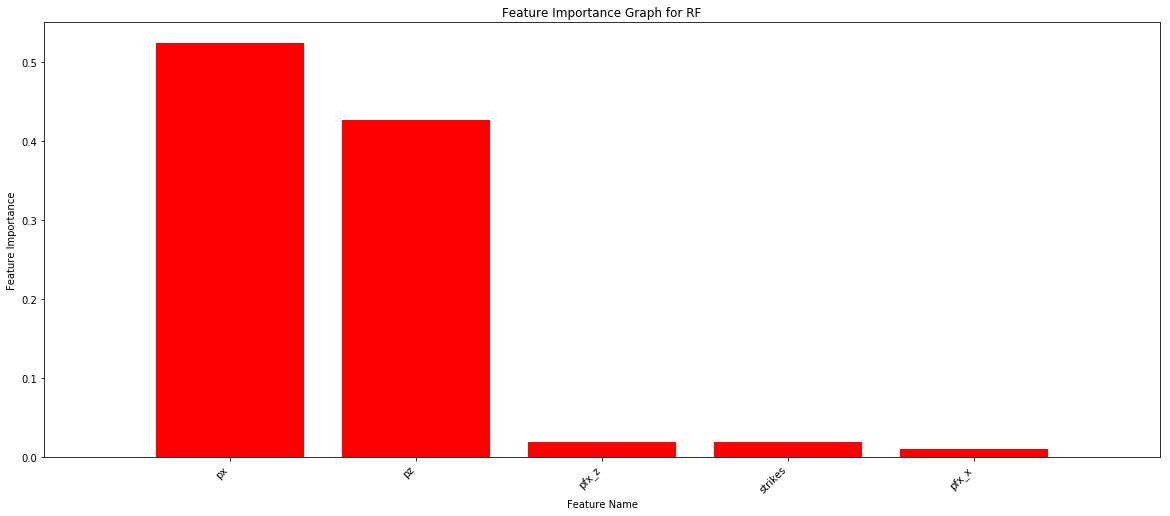

In [77]:
# RF Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
fig = plt.figure(figsize=(20,8))
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.title('Feature Importances Bar Plot')
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=45, horizontalalignment='right')
plt.xlim([-1, len(indices)])
plt.title('Feature Importance Graph for RF')
plt.show()

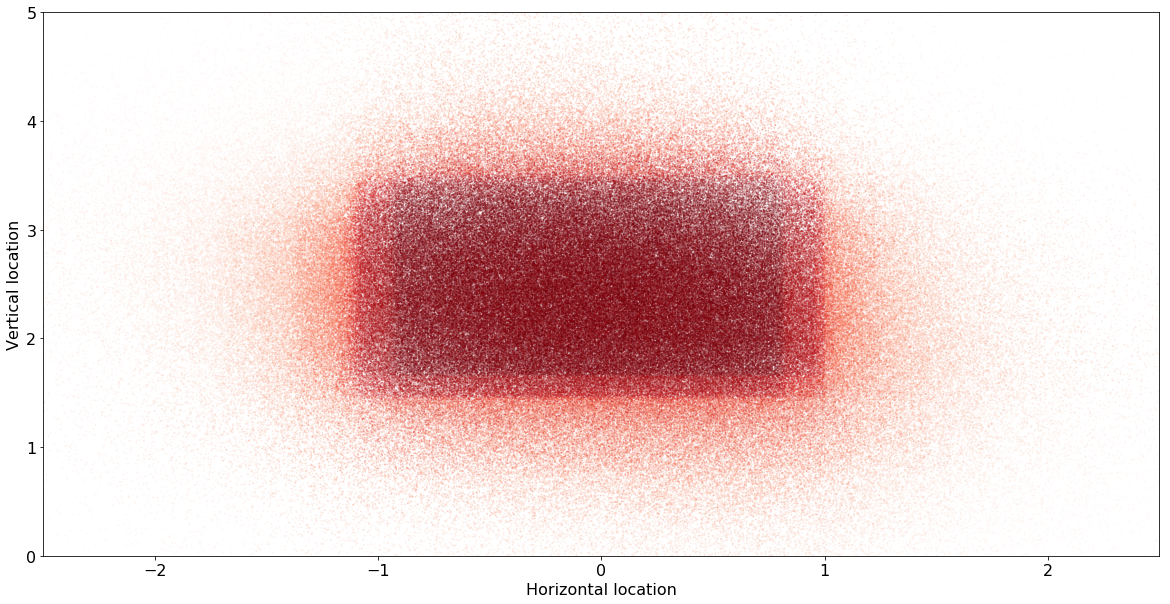

In [78]:
plt.figure(figsize=(20,10))
plt.xlim(-2.5,2.5)
plt.ylim(0,5)
plt.scatter(X_test['px'],X_test['pz'],s=.5, c=probs, alpha=0.2, cmap='Reds');
plt.xlabel('Horizontal location',fontsize=16)
plt.ylabel('Vertical location',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.legend(('Bad Pitch', 'Good Pitch'), loc='best', fontsize=16)
plt.savefig('predictions_RF.jpg')

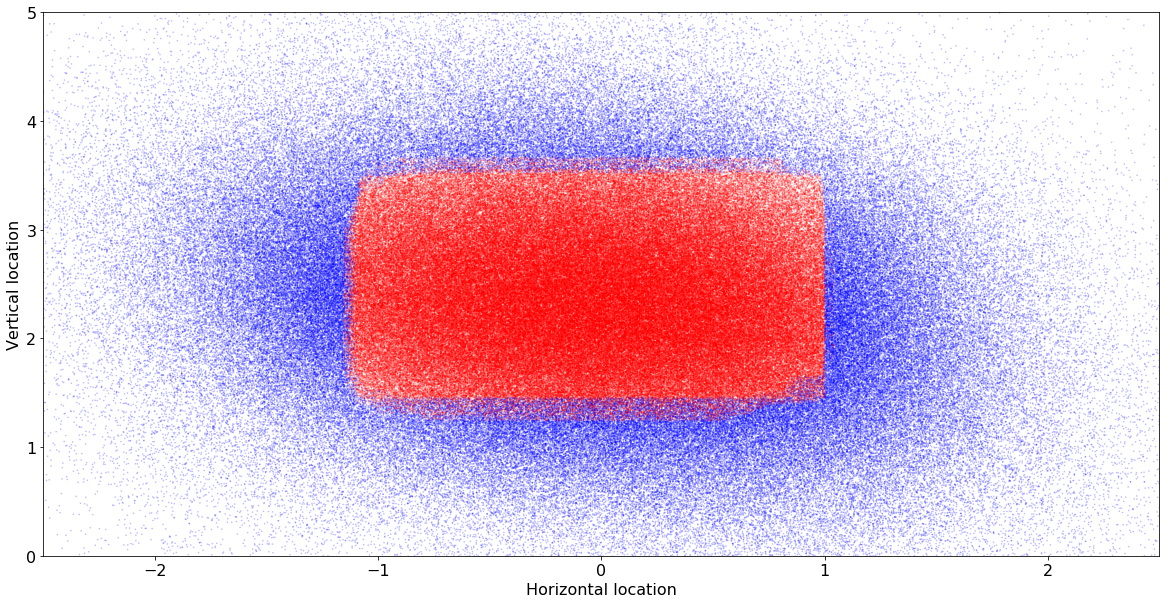

In [59]:
plt.figure(figsize=(20,10))
plt.xlim(-2.5,2.5)
plt.ylim(0,5)
plt.scatter(X_test['px'],X_test['pz'],s=.5, c=preds, alpha=0.2, cmap='bwr');
plt.xlabel('Horizontal location',fontsize=16)
plt.ylabel('Vertical location',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.legend(('Bad Pitch', 'Good Pitch'), loc='best', fontsize=16)
plt.savefig('predictions_class_RF.jpg')

In [20]:
#Get class probabilities
#probabilities_rf = model.predict_proba(X_test)
#print('\rSaving class probabilities.', end='\r')
#np.savetxt(folder_dir + 'probabilities_rf.txt', probabilities_rf, delimiter=',', newline='\n')

In [ ]:
stop=

## Logistic Regression

In [ ]:
#Create pipeline
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)
steps= [('polyfeat', PolynomialFeatures()),
         ('scaler', StandardScaler()),
         ('lr', LogisticRegression())]

mypipeline= Pipeline(steps)
parameters = dict(lr__C = [10**i for i in range(-5, 5)],
                  lr__penalty = ['l1', 'l2'])

In [ ]:
lr_grid_search= GridSearchCV(mypipeline, 
                             param_grid = parameters,  
                             scoring = 'log_loss',
                             n_jobs=-1, 
                             refit=True,
                             cv = my_cv)

lr_grid_search.fit(X_train, y_train)

In [ ]:
best_1 = lr_grid_search.best_score_
print(best_1)
lr_grid_search.best_estimator_
model=lr_grid_search.best_estimator_.steps[2][1]
print(model)

In [ ]:
model=lr_grid_search.best_estimator_.steps[2][1]

In [ ]:
probs=model.predict_proba(X_test)[:,1]
preds=model.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.2f, %s: %0.2f, %s: %0.2f '
      %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,'Majority class',majority_class))

In [ ]:
probabilities_lr=model.predict_proba(X_test)[:,1]
np.savetxt'probabilities_lr.txt', probabilities_lr, delimiter=',', newline='\n')

In [ ]:
coef_dict = {}
for coef, feat in zip(model.coef_[0],X_train.columns.tolist()):
    coef_dict[feat] = coef
coef_dict

In [ ]:
stop=

## XGBoost

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# fit model no training data
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
model = XGBClassifier()
model.fit(X_train, y_train)

# evaluate predictions
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
xgb_acc=sklearn.metrics.accuracy_score(y_test,predictions)

print(xgb_acc)

import xgboost
xgboost.plot_importance(model)

In [ ]:
param = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch1 = GridSearchCV(estimator = model, 
                        param_grid = param, 
                        scoring='roc_auc',
                        #n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, 

In [ ]:
print("Best parameters = " + str(gsearch1.best_params_))
print("Best score = " + str(gsearch1.best_score_))

In [ ]:
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)

In [ ]:
param = {
 'max_depth':[4,6],
 'min_child_weight':[4,6]
}

gsearch1 = GridSearchCV(estimator = model, 
                        param_grid = param, 
                        scoring='neg_log_loss',
                        #n_jobs=4,
                        iid=False, 
                        cv=my_cv)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_

In [ ]:
print("Best parameters = " + str(gsearch1.best_params_))
print("Best score = " + str(gsearch1.best_score_))

In [ ]:
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)

param = {
 'max_depth':[4,6],
 'min_child_weight':[4,6]
}

gsearch2 = GridSearchCV(estimator = model, 
                        param_grid = param, 
                        scoring='neg_log_loss',
                        #n_jobs=4,
                        iid=False, 
                        cv=my_cv)
gsearch2.fit(X_train,y_train)
gsearch2.grid_scores_ 

print("Best parameters = " + str(gsearch2.best_params_))
print("Best score = " + str(gsearch2.best_score_))

In [ ]:
gsearch2.best_estimator_

In [ ]:
model=gsearch2.best_estimator_
print(model)

In [ ]:
probs=model.predict_proba(X_test)[:,1]
preds=model.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.2f, %s: %0.2f, %s: %0.2f '
      %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,
        'Majority class',majority_class))

In [ ]:
my_cv = TimeSeriesSplit(n_splits=3).split(X_train)

param = {
 'max_depth':[2,5,8],
 'min_child_weight':[2,4,6]
}

gsearch3 = GridSearchCV(estimator = model, 
                        param_grid = param, 
                        scoring='neg_log_loss',
                        #n_jobs=4,
                        iid=False, 
                        cv=my_cv)
gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_ 

print("Best parameters = " + str(gsearch3.best_params_))
print("Best score = " + str(gsearch3.best_score_))

In [ ]:
model=gsearch3.best_estimator_
print(model)

In [ ]:
probs=model.predict_proba(X_test)[:,1]
preds=model.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.2f, %s: %0.2f, %s: %0.2f '
      %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,
        'Majority class',majority_class))